In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hashlib
from pydub import AudioSegment
from scipy.ndimage.morphology import (generate_binary_structure,iterate_structure, binary_erosion)
from scipy.ndimage.filters import maximum_filter
import operator
from operator import itemgetter

In [3]:
sound = AudioSegment.from_mp3(os.getcwd() + "/KJFK-Twr-Apr-19-2017-1030Z.mp3")

In [4]:
sample_rate = sound.frame_rate
sound_track = sound.get_array_of_samples()
print(sound.frame_width)
print(sound.duration_seconds)
print(sample_rate)
print(sound.dBFS)
print(sound.max)

2
1904.01306122
22050
-22.9358244513
32768


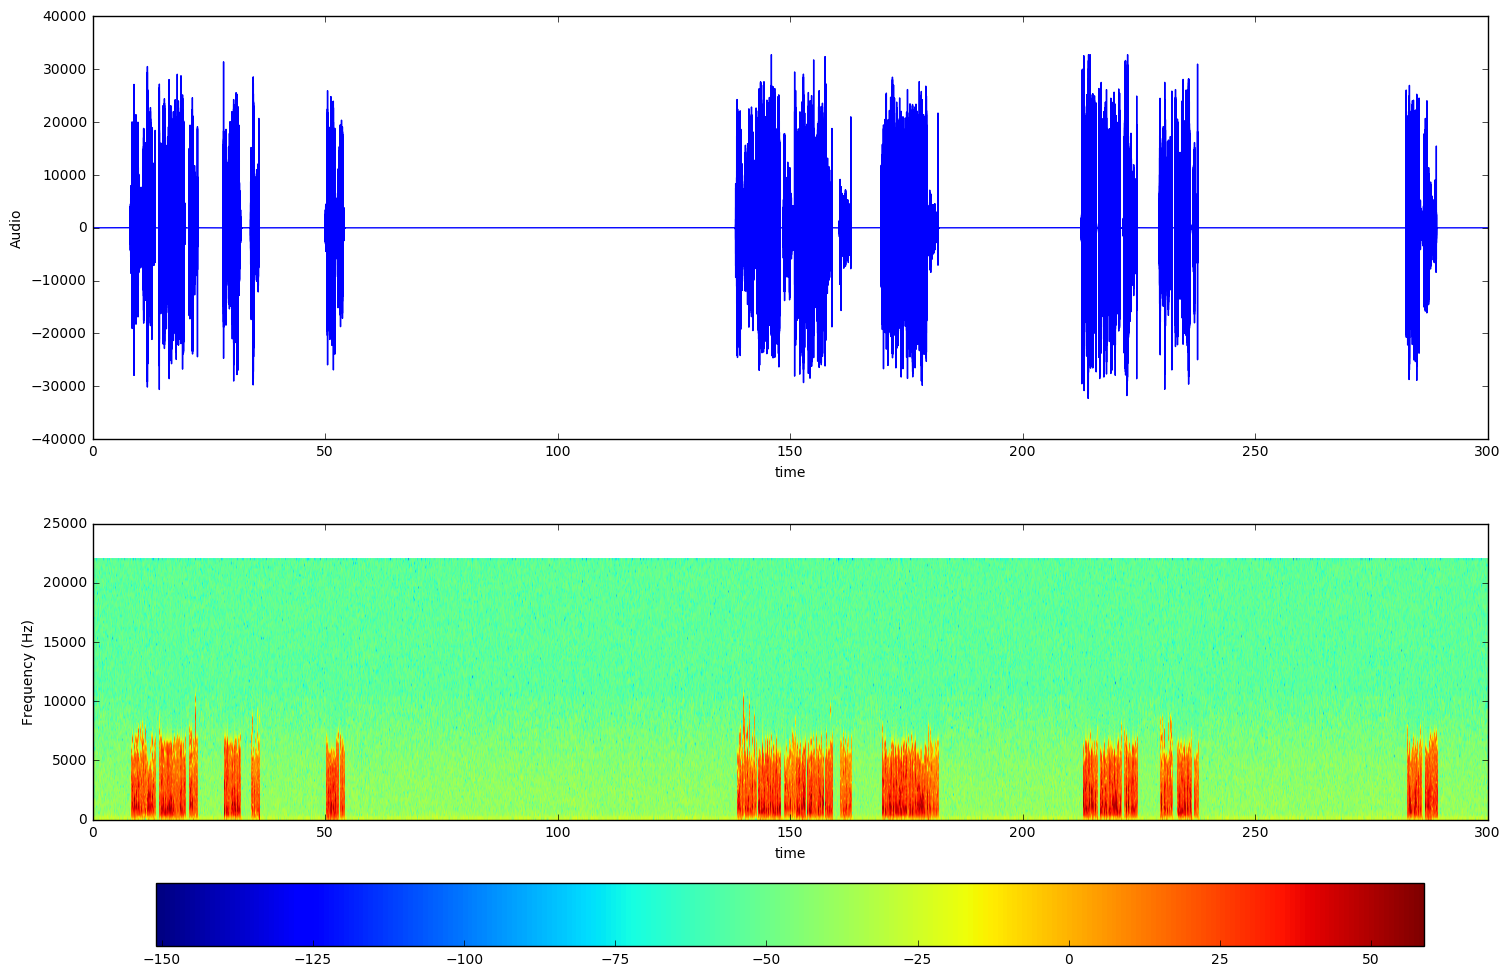

In [8]:
start_time = 0
play_sec = 300
t = np.linspace(start_time, start_time + play_sec, play_sec * sample_rate)

plt.figure(figsize=(18,12))
ax1 = plt.subplot(211)
ax1.plot(t, sound_track[start_time * sample_rate: (start_time + play_sec)*sample_rate])
ax1.set_xlabel('time')
ax1.set_ylabel('Audio')

ax2 = plt.subplot(212, sharex = ax1)
pxx5, freq5,bin5,im5= ax2.specgram(sound_track[start_time * sample_rate: (start_time + play_sec)*sample_rate], 
                                    Fs = sample_rate*2, NFFT = 256, noverlap = 128, xextent = (start_time, start_time+play_sec))
plt.colorbar(im5, orientation='horizontal')

ax2.set_xlabel('time')
ax2.set_ylabel('Frequency (Hz)')
plt.show()

In [9]:
# # apply log transform since specgram() returns linear array
pxx5 = 10 * np.log10(pxx5)
pxx5[pxx5 == -np.inf] = 0  # replace infs with zeros

/Users/dl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [10]:
IDX_FREQ_I = 0
IDX_TIME_J = 1

######################################################################
# Sampling rate, related to the Nyquist conditions, which affects
# the range frequencies we can detect.
DEFAULT_FS = sample_rate * 2

######################################################################
# Size of the FFT window, affects frequency granularity
DEFAULT_WINDOW_SIZE = 256

######################################################################
# Ratio by which each sequential window overlaps the last and the
# next window. Higher overlap will allow a higher granularity of offset
# matching, but potentially more fingerprints.
DEFAULT_OVERLAP_RATIO = 128/256

######################################################################
# Degree to which a fingerprint can be paired with its neighbors --
# higher will cause more fingerprints, but potentially better accuracy.
DEFAULT_FAN_VALUE = 15

######################################################################
# Minimum amplitude in spectrogram in order to be considered a peak.
# This can be raised to reduce number of fingerprints, but can negatively
# affect accuracy.
DEFAULT_AMP_MIN = 10

######################################################################
# Number of cells around an amplitude peak in the spectrogram in order
# for Dejavu to consider it a spectral peak. Higher values mean less
# fingerprints and faster matching, but can potentially affect accuracy.
PEAK_NEIGHBORHOOD_SIZE = 20

######################################################################
# Thresholds on how close or far fingerprints can be in time in order
# to be paired as a fingerprint. If your max is too low, higher values of
# DEFAULT_FAN_VALUE may not perform as expected.
MIN_HASH_TIME_DELTA = 0
MAX_HASH_TIME_DELTA = 200

######################################################################
# If True, will sort peaks temporally for fingerprinting;
# not sorting will cut down number of fingerprints, but potentially
# affect performance.
PEAK_SORT = True

######################################################################
# Number of bits to throw away from the front of the SHA1 hash in the
# fingerprint calculation. The more you throw away, the less storage, but
# potentially higher collisions and misclassifications when identifying songs.
FINGERPRINT_REDUCTION = 20

In [11]:
def get_2D_peaks(arr2D, plot=False, amp_min=DEFAULT_AMP_MIN):
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.morphology.iterate_structure.html#scipy.ndimage.morphology.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, PEAK_NEIGHBORHOOD_SIZE)

    # find local maxima using our fliter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                       border_value=1)

    # Boolean mask of arr2D with True at peaks
    detected_peaks = local_max - eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

    # get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]

    if plot:
        # scatter of the peaks
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(time_idx, frequency_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.show()

    return zip(frequency_idx, time_idx), amps

In [82]:
local_maxima, amps = get_2D_peaks(pxx5, plot=False, amp_min=10)

/Users/dl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


In [15]:
local_maxima

[(2, 3432),
 (2, 5487),
 (2, 9315),
 (2, 27066),
 (2, 30927),
 (2, 40665),
 (3, 3888),
 (3, 4921),
 (3, 5008),
 (3, 9094),
 (3, 24583),
 (3, 29927),
 (3, 37182),
 (3, 38683),
 (4, 2319),
 (4, 2474),
 (4, 2782),
 (4, 3277),
 (4, 3811),
 (4, 4855),
 (4, 4883),
 (4, 4944),
 (4, 4984),
 (4, 5318),
 (4, 9052),
 (4, 24102),
 (4, 24606),
 (4, 24732),
 (4, 24979),
 (4, 25328),
 (4, 26083),
 (4, 26105),
 (4, 26384),
 (4, 26556),
 (4, 26682),
 (4, 26765),
 (4, 26800),
 (4, 26899),
 (4, 27206),
 (4, 27335),
 (4, 27393),
 (4, 27731),
 (4, 27971),
 (4, 28091),
 (4, 29286),
 (4, 29337),
 (4, 29408),
 (4, 30024),
 (4, 30047),
 (4, 30119),
 (4, 30241),
 (4, 30355),
 (4, 31321),
 (4, 37284),
 (4, 37343),
 (4, 37444),
 (4, 40162),
 (4, 40246),
 (4, 40289),
 (4, 40333),
 (4, 48673),
 (4, 48828),
 (4, 48919),
 (5, 1654),
 (5, 1800),
 (5, 1847),
 (5, 2532),
 (5, 2580),
 (5, 2629),
 (5, 2666),
 (5, 2756),
 (5, 2830),
 (5, 2869),
 (5, 2898),
 (5, 2926),
 (5, 2965),
 (5, 2993),
 (5, 3034),
 (5, 3062),
 (5, 31

In [27]:
seg_len = len(sound[:300000])

In [55]:
local_maxima_freq_idx = [i[0] for i in local_maxima]
freq_idx =[x*sample_rate/ freq5.shape[0] for x in local_maxima_freq_idx]
local_maxima_time = np.asarray([item[1] for item in local_maxima])
time_idx = (local_maxima_time * seg_len / bin5.shape[0])/1000

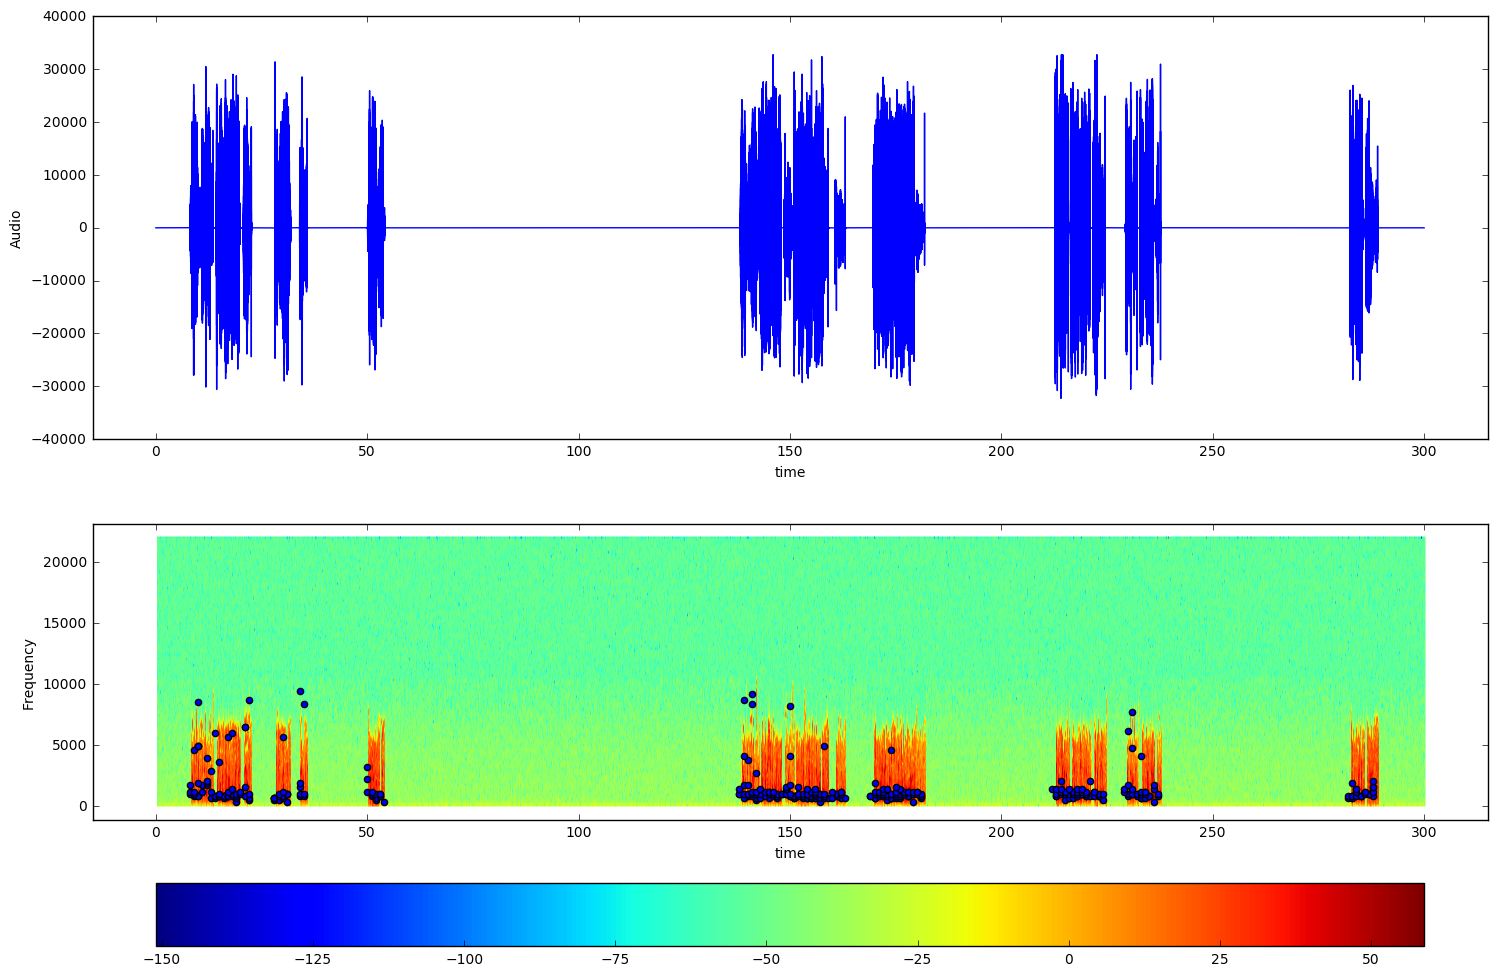

In [83]:
start_time = 0
play_sec = 300
t = np.linspace(start_time, start_time + play_sec, play_sec * sample_rate)

plt.figure(figsize=(18,12))
ax1 = plt.subplot(211)
ax1.plot(t, sound_track[start_time * sample_rate: (start_time + play_sec)*sample_rate])
ax1.set_xlabel('time')
ax1.set_ylabel('Audio')

ax2 = plt.subplot(212, sharex = ax1)
arr2d = ax2.specgram(sound_track[start_time * sample_rate: (start_time + play_sec)*sample_rate],
                                    Fs = sample_rate*2, NFFT = 256, noverlap = 128, xextent = (start_time, start_time+play_sec))
plt.colorbar(arr2d[3], orientation='horizontal')

ax2.scatter(time_idx,freq_idx)
ax2.set_xlabel('time')
ax2.set_ylabel('Frequency')
#ax2.set_ylim(0,10000)
plt.show()

In [79]:
local_maxima.sort(key = itemgetter(1))
for i in range(len(local_maxima)):
    for j in range(1,DEFAULT_FAN_VALUE):
        if(i+j)<len(local_maxima):
            
            freq1 = local_maxima[i][IDX_FREQ_I]
            freq2 = local_maxima[i+j][IDX_FREQ_I]
            t1=local_maxima[i][IDX_TIME_J]
            t2=local_maxima[i+j][IDX_TIME_J]
            t_delta = t2 - t1
            
            if t_delta >= MIN_HASH_TIME_DELTA and t_delta <=MAX_HASH_TIME_DELTA:
                h = hashlib.sha1(
                    "%s|%s|%s"% (str(freq1),str(freq2),str(t_delta)))
                h.hexdigest()[0:FINGERPRINT_REDUCTION],t1